# Summary
The following are a summary of the results from EDA (Exploratory Data Analysis), preprocessing, classifier comparisons and the final model. More details are provided in the relevant sections.

- The dataset needed to be heavily engineered to be made useful for analysis. Due to the nature of the problem, explainability was a primary focus.
- The missing values - which were very high in number - were significant predictors. For instance, applications with a missing "Marital Status", "Employment Type" or "Asset Cost" were very likely to be declined.
- Features that carried very little significance (like the digital presence features) were ignored, since they provided only a minor increase in performance at the cost of increased complexity. The final model used only 10 engineered features.
- Distinguishing between APPROVED and DECLINED classes was important, so **F1 Score** was chosen as the primary metric. **Accuracy** was used as a secondary metric.
- 20% of the training data was sampled for validation, with stratification on "Application Status" to ensure similar distribution of target across train and validation sets.
- Simple interpretable models were favored over complex ones. The baseline One-Rule model (which uses only 1 feature) achieved an F1 Score of 0.8646 and Accuracy of ~84% on the validation set.
- The final model (Decision Tree) achieved an F1 Score of **0.9023** and Accuracy of ~**87%** on the validation set.
- Visualization of the Decision Tree is provided for interpretation.

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score

# Exploratory Data Analysis

## (EDA 1 of 3) Data Description
There are 10,000 rows of training data, and 2000 rows of test data, each having 55 columns. Test data has an additional **UID** column in place of the target **Application Status**.

*Note: During preliminary analysis, It was found that most features had a similar distribution in both the training and testing set. This analysis is limited to just the training set, to simulate the situation where test data might not be available ahead of time. Most insights will still apply to both.*

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

num_duplicates = train.duplicated().sum()
train.drop_duplicates(inplace=True)
print(f'Shape (Train): {train.shape[0]} rows, {train.shape[1]} columns (after removal of {num_duplicates} duplicates)')
print(f'Shape  (Test): {test.shape[0]} rows, {test.shape[1]} columns')

Shape (Train): 9991 rows, 55 columns (after removal of 9 duplicates)
Shape  (Test): 2000 rows, 55 columns


In [3]:
def get_summary(dataset):
    # indices will be column names
    desc = pd.DataFrame(index = list(dataset))
    desc['type'] = dataset.dtypes
    desc['count'] = dataset.count()
    desc['nunique'] = dataset.nunique()
    desc['null'] = dataset.isna().sum()
    desc['%null'] = (desc['null'] / len(dataset)) * 100
    desc['min'] = dataset.min(numeric_only=True)
    desc['max'] = dataset.max(numeric_only=True)
    
    return desc.T

# get_summary(train)

There are a large number of missing values. The white gaps in the plot below indicate the location of missing values.

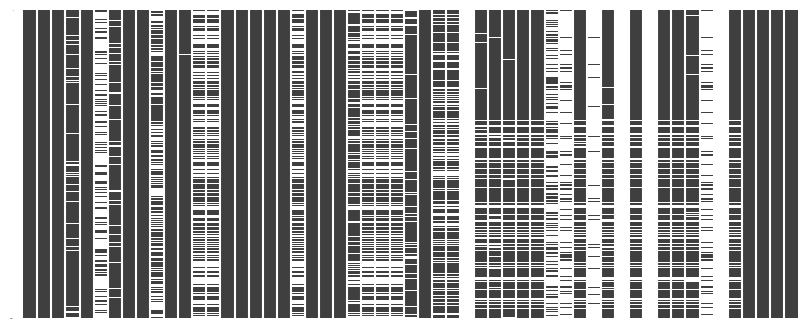

In [4]:
msno.matrix(train, figsize=(10, 4), sparkline=False, fontsize=0)
plt.show()

There is an imbalance in the target classes *APPROVED* (67%) and *DECLINED* (33%).

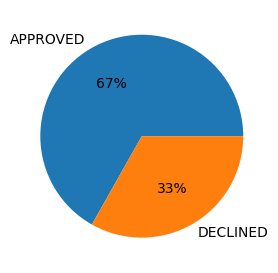

In [5]:
# helper function to build pie charts
def get_pie_data(data):
    value_counts = data.value_counts()
    return list(value_counts.index), list(value_counts.values)

labels, values = get_pie_data(train['Application Status'])

fig, ax = plt.subplots(figsize=(3, 3))
ax.pie(values, labels=labels, autopct='%1.0f%%')
fig.tight_layout()
plt.show()

None of the Aadhaars were verified but all mobile numbers were verified. These features provide no value and will not be used for the classification model.

In [6]:
verified_aadhaar = int((train['AADHAR VERIFIED'] != 'NO').mean() * 100)
verified_mobile = int((train['MOBILE VERIFICATION']).mean() * 100)
print(f"Verified Aadhaars: {verified_aadhaar}%")
print(f"Verified Mobile Numbers: {verified_mobile}%")

Verified Aadhaars: 0%
Verified Mobile Numbers: 100%


The term **approval rate** is used to refer to the ratio of approved samples to total samples. This provided a useful way to compare different groups of data.
$$\text{Approval Rate} = \frac{\text{No. of Approved Applications}}{\text{No. of Declined Applications}}$$

In [7]:
# to make approval rate calculation easier
train['target'] = train['Application Status'].map({'APPROVED': 1, 'DECLINED': 0})

Given the nature of the dataset and the class imbalance, **F1 Score** will be used as the primary metric and **Accuracy** as a secondary metric to measure model performance.

## (EDA 2 of 3) Loan Application Analysis

All applications were submitted between 03 July 2022 to 31 July 2022, with between 217 to 505 applications per day. There is a clear pattern in number of applications across days, with the lowest daily applications on weekends. There is no discernable difference in approval rates across days.

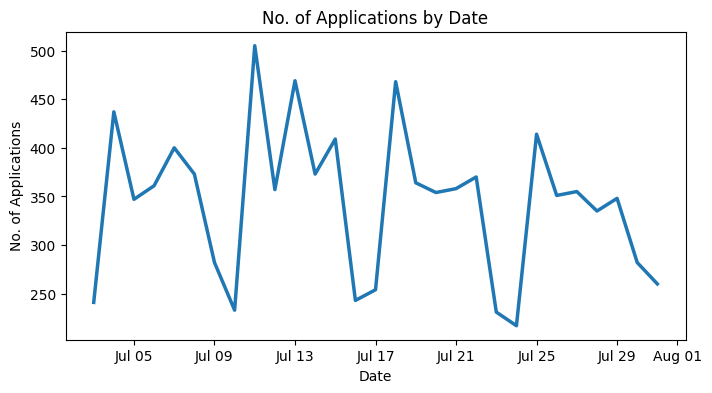

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

# date strings have mixed formats (07/20/2022, 07/04/22 etc.)
dates = pd.to_datetime(train.groupby('APPLICATION LOGIN DATE').size().keys(), format='mixed')
counts = train.groupby('APPLICATION LOGIN DATE').size().values

ax.plot(dates, counts, linewidth=2.5)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
ax.set_xlabel('Date')
ax.set_ylabel('No. of Applications')
ax.set_title('No. of Applications by Date')
plt.show()

Most application were from **Uttar Pradesh**. Haryana, Bihar and Uttar Pradesh account for 37% of all applications. Approval rates are roughly identical across states.

In [9]:
# helper function to build pareto charts
def get_pareto_data(data, column, threshold=None):
    df = data[[column, 'target']].copy()

    # group categories with frequency less than threshold
    if threshold is not None:
        value_counts = df[column].value_counts()
        others = list(value_counts[value_counts <= threshold].index)
        df.loc[df[column].isin(others), column] = 'Other'

    num_approved = df.groupby(column)['target'].sum().values
    num_declined = df.groupby(column)['target'].size().values - num_approved
    
    data = pd.DataFrame({
        'category': df.groupby(column).size().keys().str.title(),
        'approved': num_approved,
        'declined': num_declined,
        'total': num_approved + num_declined
    })
    data = data.sort_values(by='total', ascending=False)

    return data

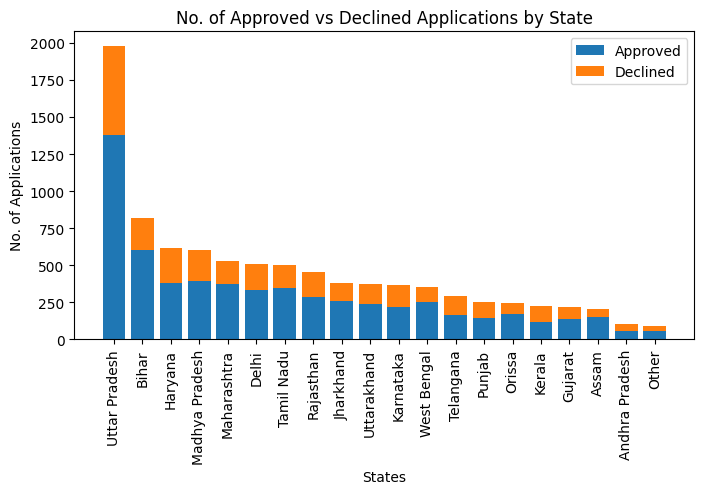

In [10]:
data = get_pareto_data(train, 'HDB BRANCH STATE', threshold=50)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(data['category'], data['approved'], label='Approved')
ax.bar(data['category'], data['declined'], bottom=data['approved'], label='Declined')

ax.set_xlabel('States')
ax.set_ylabel('No. of Applications')
ax.set_title('No. of Approved vs Declined Applications by State')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [11]:
# helper function to truncate axis labels
def format_func(categories, max_length=10):
    def inner(x, pos):
        label = categories[pos]
        return label if len(label) < max_length else f'{label[:max_length]}...'
    return inner

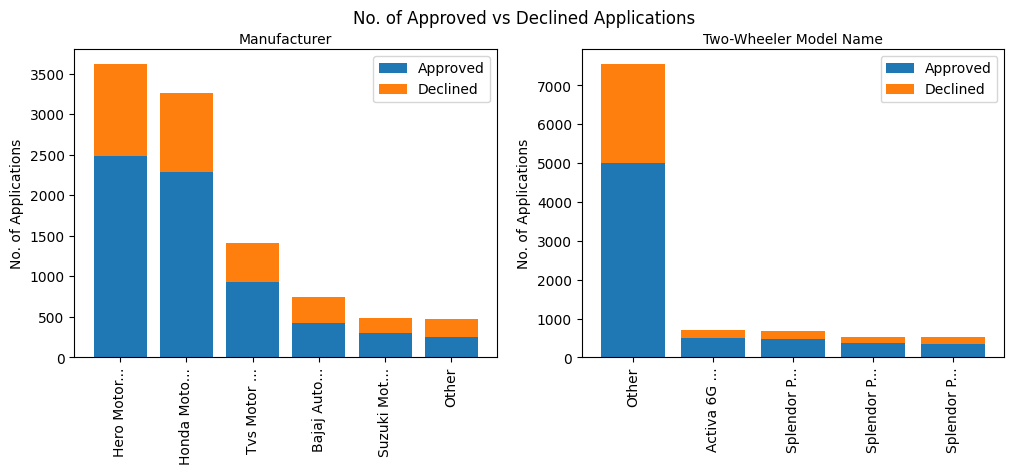

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data_maker = get_pareto_data(train, 'PRIMARY ASSET MAKE', threshold=250)
data_model = get_pareto_data(train, 'Primary Asset Model No', threshold=500)

for idx, data in enumerate([data_maker, data_model]):
    ax[idx].bar(data['category'], data['approved'], label='Approved')
    ax[idx].bar(data['category'], data['declined'], bottom=data['approved'], label='Declined')

    ax[idx].set_ylabel('No. of Applications')
    ax[idx].xaxis.set_label_position('top')
    ax[idx].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_func(data['category'].reset_index(drop=True))))
    ax[idx].legend()

    for tick in ax[idx].get_xticklabels():
        tick.set_rotation(90)

ax[0].set_xlabel('Manufacturer')
ax[1].set_xlabel('Two-Wheeler Model Name')
fig.suptitle('No. of Approved vs Declined Applications')
plt.show()

There are 2416 unique dealers. 75% of dealers sold at most 5 two-wheelers.

51% of values in two-wheeler category (**ASSET CTG**) and cost (**TOTAL ASSET COST**) are missing. All applications without a missing value in these columns were approved. Applications with missing values in these columns have a very low approval rate (35%). Missing values in asset category correspond to missing values in asset cost.

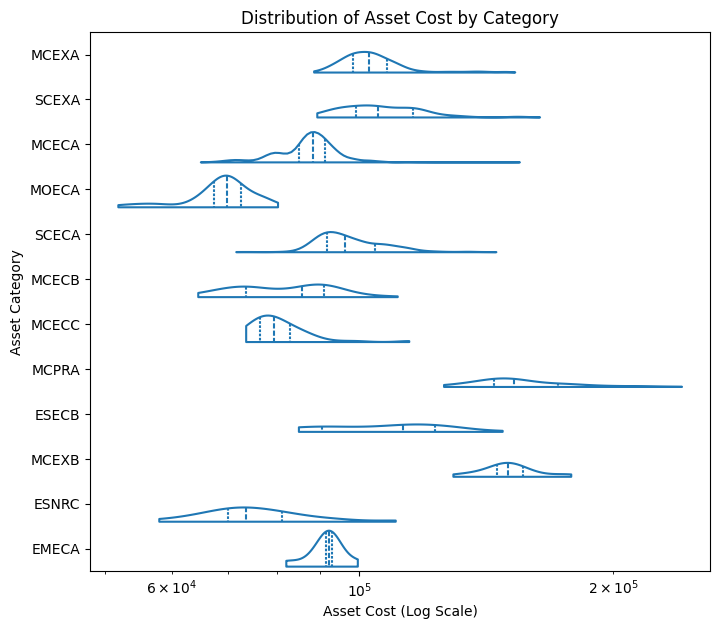

In [13]:
# drop row with ESNRB category, which only has 1 value
drop_idx = train.loc[train['ASSET CTG'] == 'ESNRB'].index[0]

fig, ax = plt.subplots(figsize=(8, 7))
sns.violinplot(data=train.drop(drop_idx), x='TOTAL ASSET COST', y='ASSET CTG', split=True, inner='quart', cut=0, fill=False, ax=ax)
ax.set_title('Distribution of Asset Cost by Category')
ax.set_ylabel('Asset Category')
ax.set_xlabel('Asset Cost (Log Scale)')
ax.set_xscale('log')
plt.show()

Ideally, the difference between applied loan amount and the two-wheeler cost should be small. But there are instances with large differences, like row 7650, where the applied amount is ₹14,20,000, for a two-wheeler that costs ₹1,42,723, an error possibly made by a mistype. The Z-score was used to detect such anomalies, using the threshold ±3. That is, any value that is 3 standard deviations away from the mean will be treated as an outlier. This matches what is found by visual inspection.

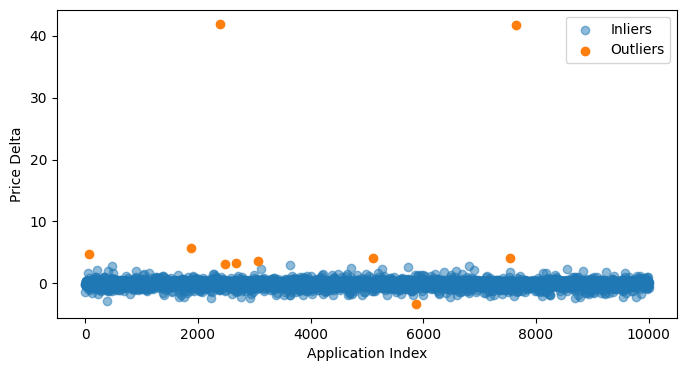

In [14]:
price_delta = (train['APPLIED AMOUNT'] - train['TOTAL ASSET COST']) / train['TOTAL ASSET COST']
price_delta = price_delta.dropna()

fig, ax = plt.subplots(figsize=(8, 4))
z_scores = (price_delta - price_delta.mean()) / price_delta.std()

inliers = z_scores[z_scores.between(-3, 3)]
outliers = z_scores[~z_scores.between(-3, 3)]

ax.scatter(inliers.index, inliers, label='Inliers', alpha=0.5)
ax.scatter(outliers.index, outliers, label='Outliers')

ax.set_xlabel('Application Index')
ax.set_ylabel('Price Delta')
plt.legend()
plt.show()

Regardless of the extreme values, all the above applications were approved. In fact, as stated earlier, *all* applications that had an asset cost specified, were approved.
Given this information, it is more beneficial to use **TOTAL ASSET COST** as an indicator variable (whether it is missing or not). There is limited value in clipping or removing these outliers.

For instances where the asset cost is not known (\~51% of the data), we cannot make a strong judgement using just the applied amount. This was verified using *Welch's t-test* and the corresponding p-value, which shows that the small difference in the mean value of applied amount across classes is not statistically significant. As such, **APPLIED AMOUNT** will not be used as a feature.

t-statistic: 5.3859
p-value: 1.0000


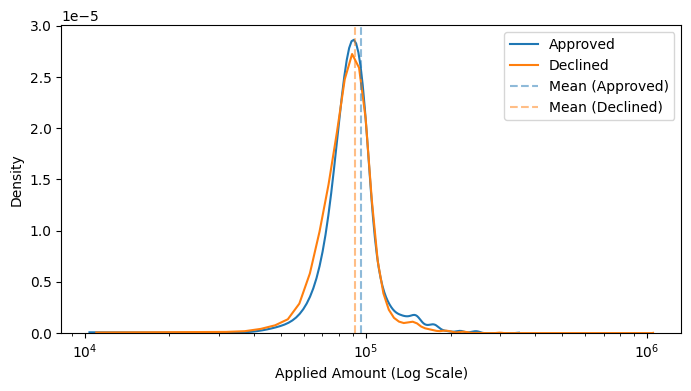

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

approved_cost = train.loc[train['TOTAL ASSET COST'].isna() & (train['target'] == 1), 'APPLIED AMOUNT']
declined_cost = train.loc[train['TOTAL ASSET COST'].isna() & (train['target'] == 0), 'APPLIED AMOUNT']

# Welch's t-test (one-sided)
result = ttest_ind(approved_cost, declined_cost, equal_var=False, alternative='less')
print(f't-statistic: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.4f}')

sns.kdeplot(approved_cost, ax=ax, cut=0, label='Approved')
sns.kdeplot(declined_cost, ax=ax, cut=0, label='Declined')
ax.axvline(approved_cost.mean(), linestyle='--', color='C0', alpha=0.5, label='Mean (Approved)')
ax.axvline(declined_cost.mean(), linestyle='--', color='C1', alpha=0.5, label='Mean (Declined)')

ax.set_xscale('log')
ax.set_xlabel('Applied Amount (Log Scale)')
plt.legend()
plt.show()

## EDA (3 of 3) Applicant Analysis

Employment details are very strong indicators of approval status. The missing values are significant, and should not be removed or imputed without consideration. Nearly all applications with a valid **EMPLOYER TYPE** were approved. Those with missing values for this column have a very low approval rate.

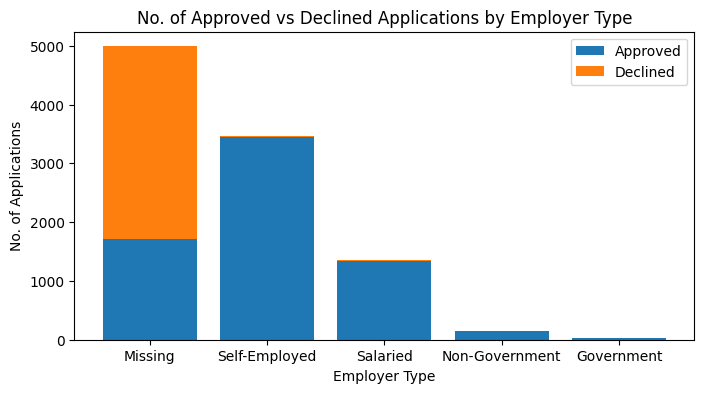

In [16]:
train['EMPLOYER_TYPE_FILLED'] = train['EMPLOYER TYPE'].fillna('MISSING')
data = get_pareto_data(train.copy(), 'EMPLOYER_TYPE_FILLED')

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(data['category'], data['approved'], label='Approved')
ax.bar(data['category'], data['declined'], bottom=data['approved'], label='Declined')

ax.set_title('No. of Approved vs Declined Applications by Employer Type')
ax.set_xlabel('Employer Type')
ax.set_ylabel('No. of Applications')
ax.legend()
plt.show()

There are many duplicates in **EMPLOYER NAME**, like "Agriculture", which is mentioned multiple types with different spellings.
**EMPLOY CONSTITUTION** is the same as **EMPLOYER TYPE**, with the subtle difference that the Non-Government and Government categories have been merged into the Salaried category.

Due to their similarity, and the significance of missing values, only a missing indicator for **EMPLOYER TYPE** will be used during model construction.

In [17]:
train['EMPLOYER NAME'].value_counts().head()

EMPLOYER NAME
agriculture      388
AGRICULTURE      155
kirana store      66
Agriculture       40
general store     35
Name: count, dtype: int64

The **Cibil Score** column has a mix of numerical, string and missing values. The two string values "NO RESPONSE" and "-" were very few in number, and were treated as missing values. Considering just the numerical values, applications with higher cibil scores were more likely to be approved. A missing indicator will also be used for this feature.

A large difference is observed between the mean cibil score across the two classes. Welch's t-test and the corresponding p-value confirm the significance of this feature.

t-statistic: 56.6828
p-value: 0.0000


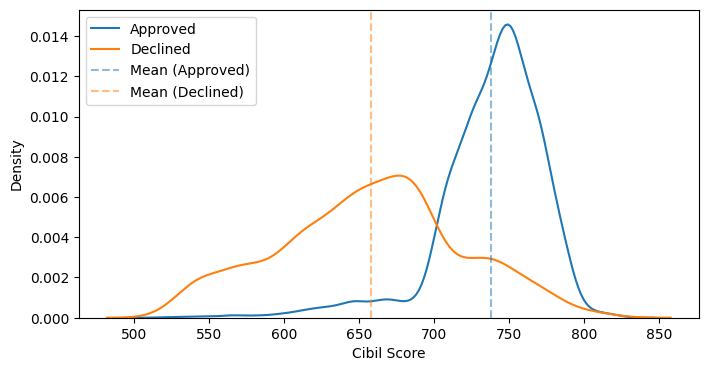

In [18]:
# comparing cibil score (numerical) and target (binary/categorical)
numerical = train[train['Cibil Score'].apply(lambda x: isinstance(x, str) and x.isdigit())][['Cibil Score', 'target']]
numerical['Cibil Score'] = numerical['Cibil Score'].astype(int)

fig, ax = plt.subplots(figsize=(8, 4))
approved_cbscore = numerical.loc[numerical['target'] == 1, 'Cibil Score']
declined_cbscore = numerical.loc[numerical['target'] == 0, 'Cibil Score']

# Welch's t-test (one-sided)
result = ttest_ind(approved_cbscore, declined_cbscore, equal_var=False, alternative='greater')
print(f't-statistic: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.4f}')

sns.kdeplot(approved_cbscore, label='Approved', ax=ax)
sns.kdeplot(declined_cbscore, label='Declined', ax=ax)
ax.axvline(approved_cbscore.mean(), linestyle='--', color='C0', alpha=0.5, label='Mean (Approved)')
ax.axvline(declined_cbscore.mean(), linestyle='--', color='C1', alpha=0.5, label='Mean (Declined)')

ax.legend()
plt.show()

Most applicants were Male and there was no significant difference in approval rates between Male and Female applicants.

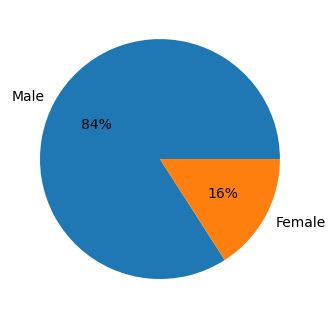

In [19]:
labels, values = get_pie_data(train['GENDER'])

fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.pie(values, labels=labels, autopct='%1.0f%%')
fig.tight_layout()

Applicants with missing or "Residence" address types were far more likely to be rejected than the other categories.

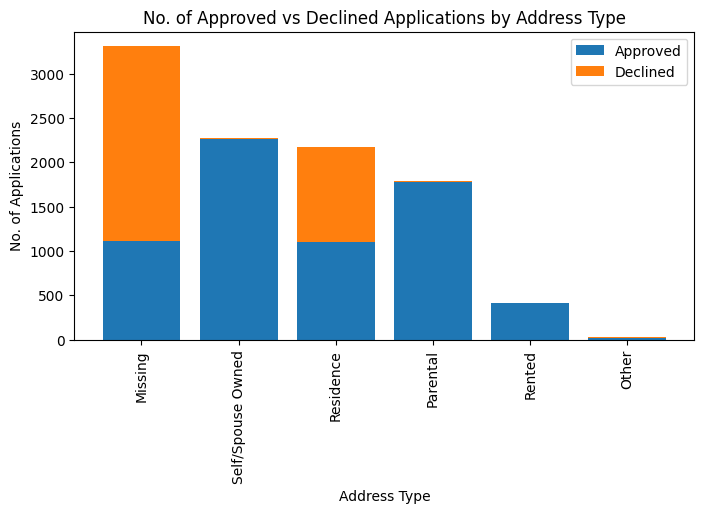

In [20]:
train['ADDRESS_TYPE_FILLED'] = train['ADDRESS TYPE'].fillna('MISSING')
data = get_pareto_data(train.copy(), 'ADDRESS_TYPE_FILLED', threshold=10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(data['category'], data['approved'], label='Approved')
ax.bar(data['category'], data['declined'], bottom=data['approved'], label='Declined')

ax.set_title('No. of Approved vs Declined Applications by Address Type')
ax.set_xlabel('Address Type')
ax.set_ylabel('No. of Applications')
ax.legend()
plt.xticks(rotation=90)
plt.show()

The zero values in **AGE** are missing values. Since date of birth **DOB** does not have missing values, we can calculate the age based on date of birth and application data to fill the missing values.

In [21]:
def apply_age_from_dob(df, default=0):
    count = 0
    apply_dates = pd.to_datetime(df['APPLICATION LOGIN DATE'], format='mixed')
    for index, dob in df.loc[df['AGE'] == 0, 'DOB'].items():
        if pd.isnull(dob):
            df.loc[index, 'AGE'] = default
            continue
        date_birth = datetime.strptime(str(dob), '%d%m%Y')
        date_applied = apply_dates[index]
        year_diff = date_applied.year - date_birth.year
        offset = (date_applied.month, date_applied.day) < (date_birth.month, date_birth.day)

        age = year_diff - offset
        df.loc[index, 'AGE'] = age
        count += 1
    print(f'Imputed {count} missing values')

Imputed 373 missing values
t-statistic: 0.2088
p-value: 0.8346


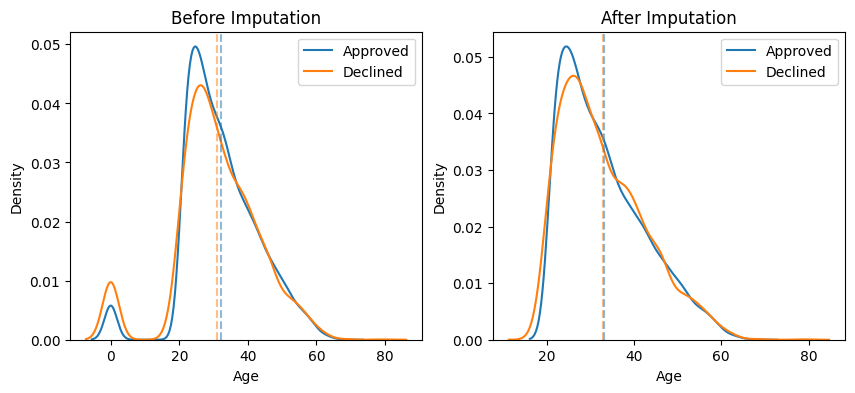

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

approved_age_before = train.loc[train['target'] == 1, 'AGE']
declined_age_before = train.loc[train['target'] == 0, 'AGE']

apply_age_from_dob(train)
approved_age_after = train.loc[train['target'] == 1, 'AGE']
declined_age_after = train.loc[train['target'] == 0, 'AGE']

# Welch's t-test (two-sided)
result = ttest_ind(approved_age_after, declined_age_after, equal_var=False)
print(f't-statistic: {result.statistic:.4f}')
print(f'p-value: {result.pvalue:.4f}')

for idx, (approved, declined) in enumerate([(approved_age_before, declined_age_before), (approved_age_after, declined_age_after)]):
    sns.kdeplot(approved, label='Approved', ax=ax[idx])
    sns.kdeplot(declined, label='Declined', ax=ax[idx])

    ax[idx].axvline(approved.mean(), linestyle='--', color='C0', alpha=0.5)
    ax[idx].axvline(declined.mean(), linestyle='--', color='C1', alpha=0.5)

    ax[idx].set_xlabel('Age')
    ax[idx].legend()

ax[0].set_title('Before Imputation')
ax[1].set_title('After Imputation')
plt.show()

After imputation, the high p-value indicates that this feature is insignificant. But there is a difference in the range of values across the two classes. Applicants younger than 21 years or older than 68 years had their applications declined. This is explained by the fact that most loan providers have age-limits beyond which they do not provide loans. This range is usually 21 to 65, but the upper end of the range is more relaxed in this case. This information is significant.

Applicants with missing **MARITAL STATUS** were more likely to have their applications declined.

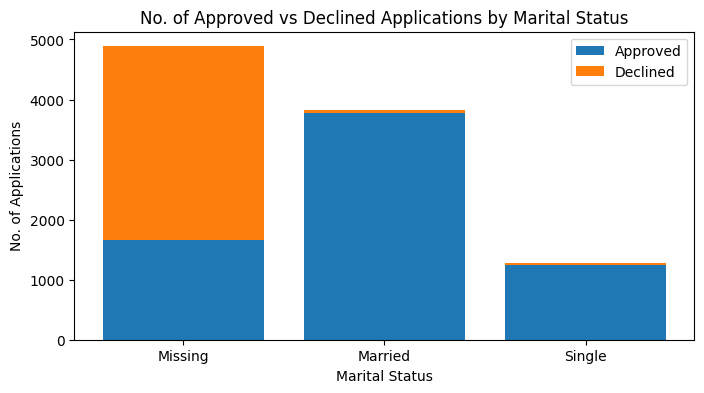

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
train['MARITAL_STATUS_FILLED'] = train['MARITAL STATUS'].fillna('MISSING')
data = get_pareto_data(train, 'MARITAL_STATUS_FILLED')

ax.bar(data['category'], data['approved'], label='Approved')
ax.bar(data['category'], data['declined'], bottom=data['approved'], label='Declined')

ax.set_title('No. of Approved vs Declined Applications by Marital Status')
ax.set_ylabel('No. of Applications')
ax.set_xlabel('Marital Status')
ax.legend()
plt.show()

Low values of **phone_nameMatchScore** indicate severe mismatch between the names obtained (or missing UPI name in several cases). Higher values indicate near-perfect matches, with only minor differences in initials and such. **-1** seems to be a special value, with a near perfect match in most cases, but missing UPI values. These should be treated separately, if the feature is used. 

More than half the values are extreme values (-1 or 100). Lower approval rates are observed for match scores less than 40, and higher approval rates for match scores greater than 40. But near-perfect match scores show no discernable difference between approved and declined cases. For these reasons, match score will not be used as a feature. **phone_digital** and **phone_phoneFootprintStrengthOverall** will also not be used.

In [24]:
def get_name(train, index):
    first_name = train.loc[index, 'FIRST NAME']
    middle_name = train.loc[index, 'MIDDLE NAME']
    last_name = train.loc[index, 'LAST NAME']
    last_name = '' if pd.isnull(last_name) else last_name

    full_name = None
    if not pd.isnull(middle_name):
        full_name = f'{first_name} {middle_name} {last_name}'.strip()
    else:
        full_name = f'{first_name} {last_name}'.strip()
    
    pan_name = train.loc[index, 'Pan Name']
    pan_name = '-' if pd.isnull(pan_name) else pan_name
    application_name = train.loc[index, 'name']
    upi_name = train.loc[index, 'upi_name']
    upi_name = '-' if pd.isnull(upi_name) else upi_name

    return f'{full_name} | {pan_name} | {application_name} | {upi_name}'

print('EXAMPLES          : Full Name | Pan Name | name | upi_name')
print(f'Match Score  (-1) : {get_name(train, 9068)}')
print(f'Match Score  (-1) : {get_name(train, 3683)}')
print(f'Match Score  (35) : {get_name(train, 1200)}')
print(f'Match Score  (78) : {get_name(train, 7419)}')
print(f'Match Score (100) : {get_name(train, 9879)}')

EXAMPLES          : Full Name | Pan Name | name | upi_name
Match Score  (-1) : NAGAR MAL | - | NAGAR MAL | -
Match Score  (-1) : PREETI | PREETI SINGH | PREETI | -
Match Score  (35) : DURGA NAND CHOPAL | DURGA NAND CHOPAL | DURGA NAND CHOPAL | Ravin  Chaupal
Match Score  (78) : SHWAHID ALI | SHWAHID ULLAH | SHWAHID ALI | SHWAHID ULLAH
Match Score (100) : JAYDEV SINGH | JAYDEV SINGH | JAYDEV SINGH | Jaydev Singh


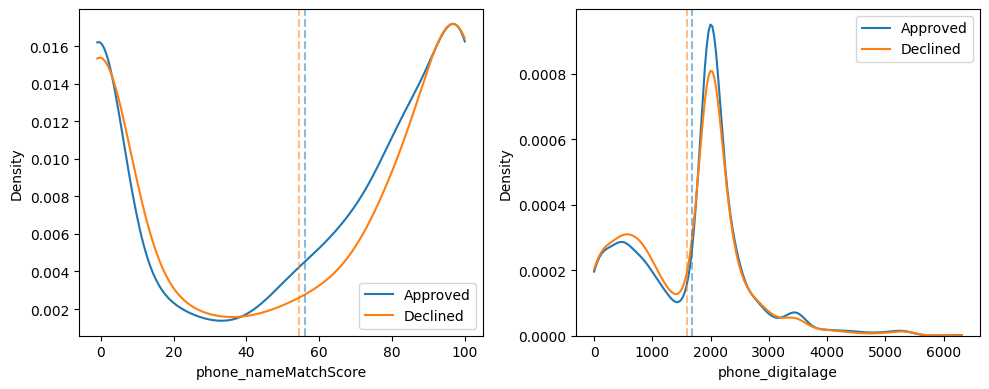

In [25]:
approved_match_score = train.loc[train['target'] == 1, 'phone_nameMatchScore']
declined_match_score = train.loc[train['target'] == 0, 'phone_nameMatchScore']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(approved_match_score, label='Approved', cut=0, ax=ax[0])
sns.kdeplot(declined_match_score, label='Declined', cut=0, ax=ax[0])

ax[0].axvline(approved_match_score.mean(), linestyle='--', color='C0', alpha=0.5)
ax[0].axvline(declined_match_score.mean(), linestyle='--', color='C1', alpha=0.5)
ax[0].legend()

approved_digitalage = train.loc[train['target'] == 1, 'phone_digitalage']
declined_digitalage = train.loc[train['target'] == 0, 'phone_digitalage']

sns.kdeplot(approved_digitalage, label='Approved', cut=0, ax=ax[1])
sns.kdeplot(declined_digitalage, label='Declined', cut=0, ax=ax[1])

ax[1].axvline(approved_digitalage.mean(), linestyle='--', color='C0', alpha=0.5)
ax[1].axvline(declined_digitalage.mean(), linestyle='--', color='C1', alpha=0.5)
ax[1].legend()

fig.tight_layout()
plt.show()

There are 20 social media features, most of which have over 50% missing values. Typically, this information would be useful. For example, the presence of certain apps, like gambling apps, might be an important indicator of the applicant's financial habits. But the values for these apps in the dataset were almost entirely missing. 

Regardless of whether a feature's value is missing, present (1) or absent (0), there is little to no difference in the approval rate. Due to their low significance, and the added complexity, these features will not be used during model construction.

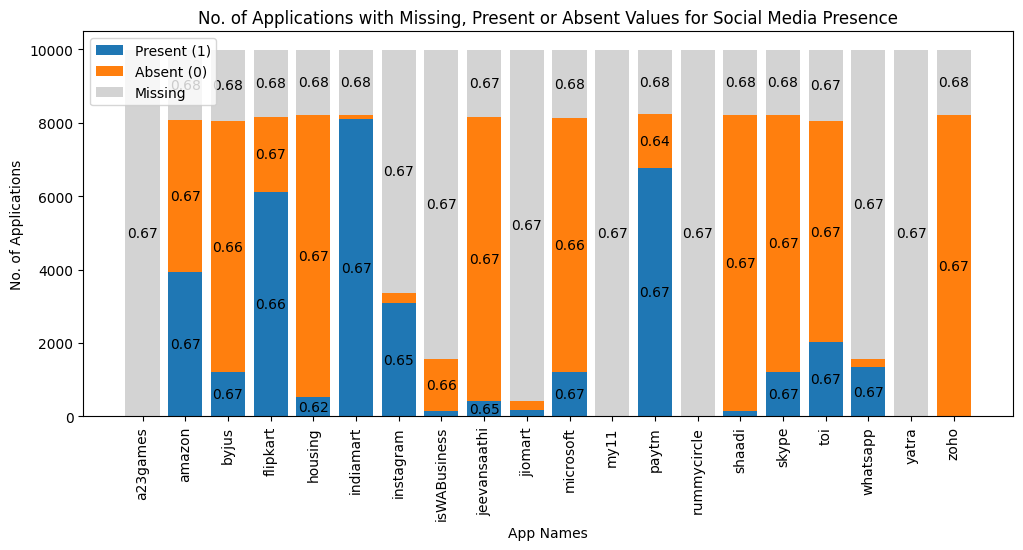

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

social_media_features = [col for col in train.columns if col.startswith('Phone Social Premium')]
apps = [x.split('.')[1] for x in social_media_features]

rates = []
npresent, nabsent, nmissing = np.zeros(len(apps)), np.zeros(len(apps)), np.zeros(len(apps))
for idx, feature in enumerate(social_media_features):
    present, absent, missing = (train[feature] == 1), (train[feature] == 0), (train[feature].isna())
    
    npresent[idx] = present.sum()
    nabsent[idx]  = absent.sum()
    nmissing[idx] = missing.sum()
    
    rate_present = train.loc[present, 'target'].mean()
    rate_absent  = train.loc[absent, 'target'].mean()
    rate_missing = train.loc[missing, 'target'].mean()

    rates.append([rate_present, rate_absent, rate_missing])

# offsets for present, absent and missing bars
offsets = (np.zeros(len(apps)), npresent, np.array(nabsent) + np.array(npresent))
bars_present = ax.bar(apps, npresent, bottom=offsets[0], label='Present (1)')
bars_absent  = ax.bar(apps, nabsent,  bottom=offsets[1], label='Absent (0)')
bars_missing = ax.bar(apps, nmissing, bottom=offsets[2], label='Missing', color='lightgray')

for i, bars in enumerate(list(zip(bars_present, bars_absent, bars_missing))):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        xpos = bar.get_x() + bar.get_width() / 2
        ypos = offsets[j][i] + height / 2

        text = '' if (pd.isnull(rates[i][j]) or (height < 300)) else f'{rates[i][j]:.2f}'
        
        plt.text(xpos, ypos, text, ha='center', va='center', color='black')

ax.set_title('No. of Applications with Missing, Present or Absent Values for Social Media Presence')
ax.set_ylabel('No. of Applications')
ax.set_xlabel('App Names')
ax.legend(loc='upper left')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

Preprocessing was done using the insights from EDA. Due to the large number of missing values, and their significance, many of the features are missing value indicators. 20% of the training data is kept for validation. The data was stratified on "Application Status" to ensure that both training and validation set had the same distribution of target values.

In [27]:
df_train = pd.read_csv('data/train.csv')
df_train.drop_duplicates(inplace=True)

original_cols = df_train.columns

In [28]:
# keep 20% of the data for validation, ensuring that it has the same distribution of targets as training set
train, valid = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42, stratify=df_train['Application Status'])

print(f'Train: {train.shape[0]} rows, {train.shape[1]} columns')
print(f'Test : {valid.shape[0]} rows, {valid.shape[1]} columns')

Train: 7992 rows, 55 columns
Test : 1999 rows, 55 columns


In [29]:
# impute missing values in age
apply_age_from_dob(train)
apply_age_from_dob(valid)

Imputed 302 missing values
Imputed 71 missing values


In [30]:
# cibil scores have a mix of numerical (stored as string), string and missing values.
# convert numerical strings to int, and treat all other values as missing values
def transform_cibil_score(x):
    if isinstance(x, str) and x.isdigit():
        return int(x)
    return np.nan

# group address types into these four categories
address_categories = ['missing', 'residence', 'owned_parental_rented', 'other']
def transform_address(x):
    if pd.isnull(x):
        return 'missing'
    if x == 'RESIDENCE':
        return 'residence'
    if x in ('Self/Spouse Owned', 'Parental', 'Rented'):
        return 'owned_parental_rented'
    return 'other'

In [31]:
def preprocess(train, test):
    # binary encoding for gender
    gender_map = {'Male': 1, 'Female': 0}
    train['gender'] = train['GENDER'].map(gender_map)
    test['gender'] = test['GENDER'].map(gender_map)

    # add missing indicators for asset cost, marital status and employment status
    old_cols = ['TOTAL ASSET COST', 'MARITAL STATUS', 'EMPLOYER TYPE']
    new_cols = ['asset_cost_missing', 'marital_status_missing', 'employ_missing']
    train[new_cols] = train[old_cols].isna().astype(int)
    test[new_cols] = test[old_cols].isna().astype(int)

    # treat non-numerical cibil scores as missing
    train['cibil_score'] = train['Cibil Score'].apply(transform_cibil_score)
    test['cibil_score'] = test['Cibil Score'].apply(transform_cibil_score)
    # min-max scale cibil scores that are not missing
    scaler = MinMaxScaler()
    train['cibil_score'] = scaler.fit_transform(train[['cibil_score']])
    test['cibil_score'] = scaler.transform(test[['cibil_score']])
    # add indicator for missing cibil score
    train['cibil_missing'] = train['cibil_score'].isna().astype(int)
    test['cibil_missing'] = test['cibil_score'].isna().astype(int)
    # fill missing cibil scores with -1
    train['cibil_score'] = train['cibil_score'].fillna(-1)
    test['cibil_score'] = test['cibil_score'].fillna(-1)

    # 1 if age is outside the range [21, 68], 0 otherwise
    train['age_outlier'] = (~train['AGE'].between(21, 68)).astype(int)
    test['age_outlier'] = (~test['AGE'].between(21, 68)).astype(int)

    # one-hot encode address type
    def address_concat(x, cat):
        return 'address_' + cat
        
    train_address = train['ADDRESS TYPE'].apply(transform_address).values.reshape(-1, 1)
    test_address = test['ADDRESS TYPE'].apply(transform_address).values.reshape(-1, 1)
    
    encoder = OneHotEncoder(sparse_output=False, dtype=int, drop=['other'], feature_name_combiner=address_concat)
    train[encoder.get_feature_names_out()] = encoder.fit_transform(train_address)
    test[encoder.get_feature_names_out()] = encoder.transform(test_address)

    target_map = {'APPROVED': 1, 'DECLINED': 0}
    train['target'] = train['Application Status'].map(target_map)

    # if 'test' is a validation set
    if 'Application Status' in test.columns:
        test['target'] = test['Application Status'].map(target_map)
    
    return train.drop(columns=original_cols), test.drop(columns=original_cols, errors='ignore')

train, valid = preprocess(train, valid)
# train.head()

In [32]:
print('Memory Usage (Train):', train.memory_usage().sum()//1024, 'KB')
print('Memory Usage (Valid):', valid.memory_usage().sum()//1024, 'KB')

Memory Usage (Train): 1007 KB
Memory Usage (Valid): 251 KB


In [33]:
X_train = train.drop(columns=['target'])
y_train = train['target']

X_valid = valid.drop(columns=['target'])
y_valid = valid['target']

# Baseline Models

## One-Rule Classifier

Due to the high predictive power of the missing categories, the simplest of classifiers was used to set a baseline. The One-Rule classifier uses a single feature value (rule) to make the prediction. The missing indication for Marital Status provided the most effective rule:
$$\text{\textbf{Declined} if Marital Status is missing, else \textbf{Approved}}$$
This simple rule can predict approval status with **~84%** accuracy, with an F1-Score of **0.8646**

F1 Score: 0.8646
Accuracy: 0.8389


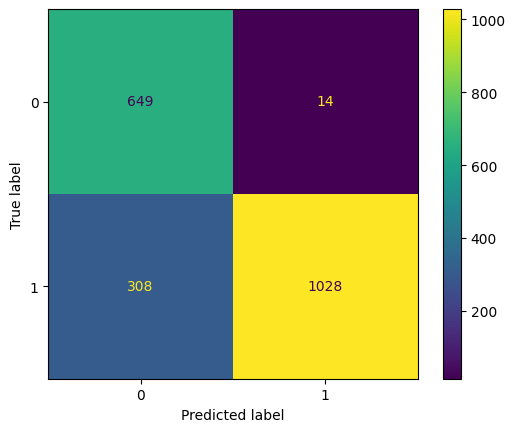

In [34]:
# asset_cost_missing is another potential candidate, with a perfect precision score (but worse recall, and overall worse f1-score)
preds = 1 - X_valid['marital_status_missing'] 

baseline_accuracy = accuracy_score(y_valid, preds)
baseline_f1score = f1_score(y_valid, preds)
print(f'F1 Score: {baseline_f1score:.4f}')
print(f'Accuracy: {baseline_accuracy:.4f}')

ConfusionMatrixDisplay.from_predictions(y_valid, preds)
plt.show()

## Classifier Comparison
Various classifiers were compared to find a good balance between interpretability and predictive power. Given the large number of binary features, it would be fair to assume that a Decision Tree classifier (that can easily make splits on these features) would perform well. The comparison shows that this is indeed the case.

F1 Score: 0.8908, Accuracy: 0.8624 (Logistic Regression)
F1 Score: 0.8984, Accuracy: 0.8619 (KNN)
F1 Score: 0.9023, Accuracy: 0.8729 (Decision Tree)
F1 Score: 0.9039, Accuracy: 0.8744 (Random Forest)


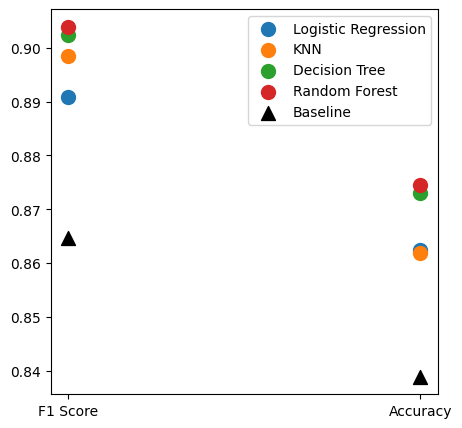

In [35]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=0)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=42, max_depth=6, n_estimators=60))
]

fig, ax = plt.subplots(figsize=(5, 5))

for name, model in models:
    model.fit(X_train, y_train)

    preds = model.predict(X_valid)
    score_f1 = f1_score(y_valid, preds)
    score_accuracy = accuracy_score(y_valid, preds)

    print(f'F1 Score: {score_f1:.4f}, Accuracy: {score_accuracy:.4f} ({name})')
    ax.scatter(['F1 Score', 'Accuracy'], [score_f1, score_accuracy], label=name, s=100)

ax.scatter(['F1 Score', 'Accuracy'], [baseline_f1score, baseline_accuracy], label='Baseline', color='black', s=100, marker='^')
ax.legend()
plt.show()


Although the Random Forest had slightly higher accuracy and F1-Score, the **Decision Tree**  was chosen as the final model due to its simplicity and interpretability.

# Final Classifier

In [36]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.drop_duplicates(inplace=True)

In [37]:
print(f'Train: {train.shape[0]} rows, {train.shape[1]} columns')
print(f'Test : {test.shape[0]} rows, {test.shape[1]} columns')

Train: 9991 rows, 55 columns
Test : 2000 rows, 55 columns


In [38]:
train, test = preprocess(train, test)

In [39]:
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['UID'])

In [40]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(X_train, y_train)

final_preds = clf.predict(X_test)

*Note: The decision tree shown is visualized only to a depth of 2. The full figure is provided in a file named "decision_tree.png".*

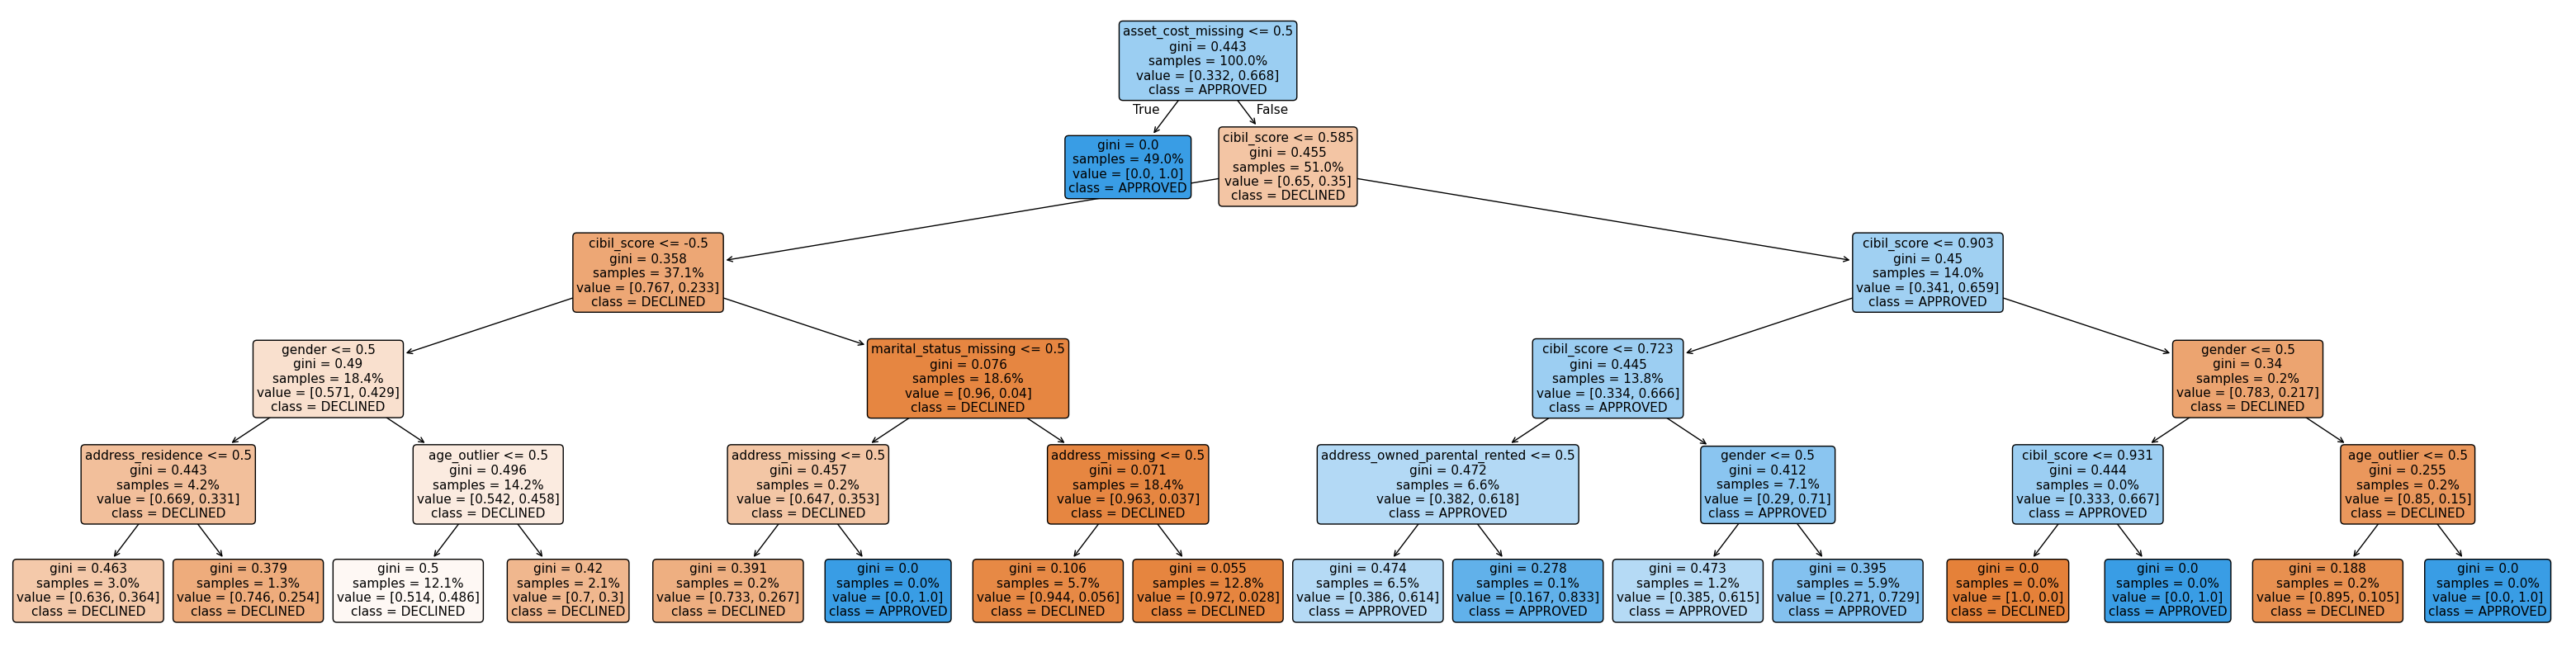

In [58]:
fig, ax = plt.subplots(figsize=(40, 10))
plot_tree(clf, feature_names=X_train.columns, class_names=['DECLINED', 'APPROVED'], rounded=True, filled=True, proportion=True, ax=ax, fontsize=11)
# plt.savefig('decision_tree.png', dpi=200)
plt.show()

In [42]:
mapped_preds = pd.DataFrame({
    'UID': test['UID'],
    'Prediction': final_preds
})
mapped_preds['Prediction'] = mapped_preds['Prediction'].map({1: 'APPROVED', 0: 'DECLINED'})
mapped_preds['Prediction'].value_counts()

Prediction
APPROVED    1246
DECLINED     754
Name: count, dtype: int64

In [43]:
mapped_preds.to_csv('predictions.csv', index=False)